In [1]:
import ast
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GATConv

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def CalculateWeight(num_messages, viral_strenght):
    if viral_strenght == 0:
        viral_strenght = 0.001
    else:
        viral_strenght = viral_strenght / 1000
    return num_messages * viral_strenght

def CreateMessageGraph(file_path):
    data = pd.read_csv(file_path)
    data['group_list'] = data['group_list'].apply(ast.literal_eval)
    viralStrengthDict = data.set_index('id')['viral_strenght'].to_dict()
    groupDict = {}

    for _, row in data.iterrows():
        user_id = row['id']
        for group in row['group_list']:
            for group_id, message_count in group.items():
                groupDict.setdefault(group_id, []).append((user_id, message_count))

    G = nx.DiGraph()
    for _, row in data.iterrows():
        node_id = row['id']
        node_attributes = row.drop('group_list').to_dict()
        G.add_node(node_id, **node_attributes)

    for group_id, users in groupDict.items():
        for i, (user_i, messages_i) in enumerate(users):
            for user_j, messages_j in users:
                if user_i != user_j:
                    w = CalculateWeight(messages_i, viralStrengthDict.get(user_i))
                    if G.has_edge(user_i, user_j):
                        G[user_i][user_j]['weight'] += w
                    else:
                        G.add_edge(user_i, user_j, weight=w)
    return G

def ExtractNodeFeatures(G, node_list=None):
    features = []
    if node_list is None:
        node_list = list(G.nodes())
    for node in node_list:
        node_data = G.nodes[node]
        vector = [
            node_data.get('groups'),
            node_data.get('number_of_messages'),
            node_data.get('texts'),
            node_data.get('text_ratio'),
            node_data.get('midia'),
            node_data.get('midia_ratio'),
            node_data.get('virals'),
            node_data.get('repeated_messages'),
            node_data.get('strenght'),
            node_data.get('viral_strenght')
        ]
        features.append(vector)
    return np.array(features)

In [3]:
def CreateGraphSplits(G, X, y, val_ratio=0.15, test_ratio=0.15, random_state=42):
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    num_nodes = G.number_of_nodes()
    node_indices = np.arange(num_nodes)
    n_clusters = max(1, min(20, num_nodes // 50))
    clustering = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    node_clusters = clustering.labels_
    unique_clusters = np.unique(node_clusters)
    train_idx, val_idx, test_idx = [], [], []
    for cluster in unique_clusters:
        cluster_mask = node_clusters == cluster
        cluster_indices = node_indices[cluster_mask]
        for label in torch.unique(y):
            cluster_indices_t = torch.from_numpy(cluster_indices)
            label_mask = (y[cluster_indices_t] == label)
            label_indices = cluster_indices[label_mask.cpu().numpy()]
            if len(label_indices) == 0:
                continue
            np.random.shuffle(label_indices)
            n_test = max(1, int(test_ratio * len(label_indices)))
            n_val = max(1, int(val_ratio * len(label_indices)))
            if n_test + n_val > len(label_indices):
                if len(label_indices) > 1:
                    n_test = 1
                    n_val = 1 if len(label_indices) > 2 else 0
                else:
                    n_test = 1
                    n_val = 0
            test_idx.extend(label_indices[:n_test])
            val_idx.extend(label_indices[n_test:n_test+n_val])
            train_idx.extend(label_indices[n_test+n_val:])
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    assert not torch.any(train_mask & val_mask)
    assert not torch.any(train_mask & test_mask)
    assert not torch.any(val_mask & test_mask)
    print(f"Train: {train_mask.sum().item()} nodes ({train_mask.sum().item()/num_nodes:.2%})")
    print(f"Val: {val_mask.sum().item()} nodes ({val_mask.sum().item()/num_nodes:.2%})")
    print(f"Test: {test_mask.sum().item()} nodes ({test_mask.sum().item()/num_nodes:.2%})")
    print('Distribuição de classes:')
    print('Train:', torch.bincount(y[train_mask]).numpy())
    print('Val  :', torch.bincount(y[val_mask]).numpy())
    print('Test :', torch.bincount(y[test_mask]).numpy())
    return train_mask, val_mask, test_mask

def TrainTestSplit(indices, test_size, random_state, stratify=None):
    from sklearn.model_selection import train_test_split as sklearn_split
    return sklearn_split(indices, test_size=test_size, random_state=random_state, stratify=stratify)

In [4]:
class GATNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate,
                 heads_layer1=4, heads_layer2=4, final_heads=1, attn_dropout=0.2):
        super().__init__()

        self.gat1 = GATConv(in_channels=input_dim, out_channels=hidden_dim1, heads=heads_layer1,
                            dropout=attn_dropout, concat=True)

        self.gat2 = GATConv(in_channels=hidden_dim1 * heads_layer1,
                            out_channels=hidden_dim2, heads=heads_layer2,
                            dropout=attn_dropout, concat=True)

        self.gat_out = GATConv(in_channels=hidden_dim2 * heads_layer2,
                               out_channels=output_dim, heads=final_heads,
                               dropout=attn_dropout, concat=False)
        
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim1 * heads_layer1)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim2 * heads_layer2)
        self.dropout_rate = dropout_rate
        self.attn_dropout = attn_dropout

    def forward(self, x, edge_index):

        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.gat_out(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [5]:
def FindBestThreshold(y_true, positive_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, positive_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5
    return best_threshold

def EvaluateModel(model, data, mask=None, threshold=None, dataset_name="Dataset", return_metrics=False):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        y_prob = torch.exp(output)[:, 1].cpu().numpy()
        y_true = data.y.cpu().numpy()
        if mask is not None:
            mask_np = mask.cpu().numpy()
            y_true = y_true[mask_np]
            y_prob = y_prob[mask_np]
        if threshold is None:
            threshold = FindBestThreshold(y_true, y_prob)
        y_pred = (y_prob >= threshold).astype(int)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0
        conf_matrix = confusion_matrix(y_true, y_pred)
        fp = conf_matrix[0][1] if conf_matrix.shape[0] > 1 and conf_matrix.shape[1] > 1 else 0
        fn = conf_matrix[1][0] if conf_matrix.shape[0] > 1 and conf_matrix.shape[1] > 1 else 0
        total_positives = sum(y_true)
        true_positives = ((y_pred == 1) & (np.array(y_true) == 1)).sum()
        percentage_identified = (true_positives / total_positives * 100) if total_positives > 0 else 0.0
        print(f"\nEvaluation on {dataset_name}:")
        print(f"  Accuracy: {accuracy:.6f}")
        print(f"  Precision: {precision:.6f}")
        print(f"  Recall: {recall:.6f}")
        print(f"  F1 Score: {f1:.6f}")
        print(f"  AUC: {auc:.6f}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  Percentage of misinformers identified: {percentage_identified:.5f}%")
        if return_metrics:
            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'fp': fp,
                'fn': fn,
                'percentage_identified': percentage_identified,
                'threshold': threshold
            }

In [6]:
DEFAULT_HIDDEN_DIM1 = 64
DEFAULT_HIDDEN_DIM2 = 32
DEFAULT_DROPOUT_RATE = 0.3
DEFAULT_LEARNING_RATE = 0.01
DEFAULT_WEIGHT_DECAY = 5e-4
DEFAULT_EPOCHS = 200
DEFAULT_EARLY_STOPPING_PATIENCE = 40

def KFoldCrossValidation(data, k=5, epochs=DEFAULT_EPOCHS, hidden_dim1=DEFAULT_HIDDEN_DIM1,
                         hidden_dim2=DEFAULT_HIDDEN_DIM2, dropout_rate=DEFAULT_DROPOUT_RATE,
                         lr=DEFAULT_LEARNING_RATE, weight_decay=DEFAULT_WEIGHT_DECAY,
                         early_stopping_patience=DEFAULT_EARLY_STOPPING_PATIENCE,
                         heads_layer1=4, heads_layer2=4, final_heads=1, attn_dropout=0.2):

    node_indices = np.arange(data.num_nodes)
    labels = data.y.numpy()
    X_all = data.x.numpy()
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_val_idx, test_idx) in enumerate(skf.split(node_indices, labels)):
        print(f"\n{'='*55}\nFold {fold+1}/{k}\n{'='*55}")
        train_idx, val_idx = TrainTestSplit(train_val_idx, test_size=0.2, random_state=42, stratify=labels[train_val_idx])
        scaler = StandardScaler().fit(X_all[train_idx])
        X_fold = scaler.transform(X_all)
        data_fold = Data(x=torch.tensor(X_fold, dtype=torch.float), edge_index=data.edge_index, y=data.y)
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool); train_mask[train_idx] = True
        val_mask = torch.zeros(data.num_nodes, dtype=torch.bool); val_mask[val_idx] = True
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool); test_mask[test_idx] = True
        print(f"Train: {train_mask.sum()}  Val: {val_mask.sum()}  Test: {test_mask.sum()}")
        input_dim = data_fold.x.size(1)
        output_dim = 2
        model = GATNet(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate,
                       heads_layer1=heads_layer1, heads_layer2=heads_layer2,
                       final_heads=final_heads, attn_dropout=attn_dropout)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        class_counts = torch.bincount(data_fold.y[train_mask])
        class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))
        criterion = torch.nn.NLLLoss(weight=class_weights)
        best_val_loss = float('inf')
        best_state = None
        patience = 0
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data_fold.x, data_fold.edge_index)
            loss = criterion(out[train_mask], data_fold.y[train_mask])
            loss.backward()
            optimizer.step()
            model.eval()
            with torch.no_grad():
                out = model(data_fold.x, data_fold.edge_index)
                val_loss = criterion(out[val_mask], data_fold.y[val_mask])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = model.state_dict()
                patience = 0
            else:
                patience += 1
            if patience >= early_stopping_patience:
                print(f"Early stopping (epoch {epoch})")
                break
            if epoch % 20 == 0:
                print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
        if best_state:
            model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            out = model(data_fold.x, data_fold.edge_index)
            val_probs = torch.exp(out[val_mask])[:, 1].cpu().numpy()
            val_labels = data_fold.y[val_mask].cpu().numpy()
        threshold = FindBestThreshold(val_labels, val_probs)
        metrics = EvaluateModel(model, data_fold, test_mask, threshold=threshold,
                                dataset_name=f"Fold {fold+1} Test Set", return_metrics=True)
        fold_metrics.append(metrics)
    avg_metrics = {k: sum(f[k] for f in fold_metrics)/len(fold_metrics) for k in fold_metrics[0]}
    print("\n================= MÉDIA DOS FOLDS =================")
    print(f"Accuracy: {avg_metrics['accuracy']:.6f}")
    print(f"Precision: {avg_metrics['precision']:.6f}")
    print(f"Recall: {avg_metrics['recall']:.6f}")
    print(f"F1: {avg_metrics['f1']:.6f}")
    print(f"AUC: {avg_metrics['auc']:.6f}")
    print(f"FP médio: {avg_metrics['fp']:.2f}")
    print(f"FN médio: {avg_metrics['fn']:.2f}")
    print(f"% Identificados (médio): {avg_metrics['percentage_identified']:.5f}%")
    return {'avg_metrics': avg_metrics, 'fold_metrics': fold_metrics}

Number of nodes: 5364
Number of edges: 1125326
Train: 3754 nodes (69.99%)
Val: 535 nodes (9.97%)
Test: 1075 nodes (20.04%)
Distribuição de classes:
Train: [3665   89]
Val  : [522  13]
Test : [1045   30]

Iniciando k-fold cross-validation com GAT...

Fold 1/5
Train: 3432  Val: 859  Test: 1073


C:\Users\User\AppData\Local\Temp\ipykernel_4804\1815770954.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 000 | Train Loss: 3.8145 | Val Loss: 2.5486
Epoch 020 | Train Loss: 0.6559 | Val Loss: 0.7049
Epoch 040 | Train Loss: 0.6489 | Val Loss: 0.8176
Epoch 060 | Train Loss: 0.6272 | Val Loss: 0.6682
Early stopping (epoch 64)

Evaluation on Fold 1 Test Set:
  Accuracy: 0.946878
  Precision: 0.000000
  Recall: 0.000000
  F1 Score: 0.000000
  AUC: 0.716406
  False Positives: 31
  False Negatives: 26
  Percentage of misinformers identified: 0.00000%

Fold 2/5
Train: 3432  Val: 859  Test: 1073


C:\Users\User\AppData\Local\Temp\ipykernel_4804\1815770954.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 000 | Train Loss: 1.1272 | Val Loss: 4.5465
Epoch 020 | Train Loss: 0.6044 | Val Loss: 0.6823
Epoch 040 | Train Loss: 0.5800 | Val Loss: 0.7008
Early stopping (epoch 52)

Evaluation on Fold 2 Test Set:
  Accuracy: 0.813607
  Precision: 0.046875
  Recall: 0.346154
  F1 Score: 0.082569
  AUC: 0.538829
  False Positives: 183
  False Negatives: 17
  Percentage of misinformers identified: 34.61538%

Fold 3/5
Train: 3432  Val: 859  Test: 1073


C:\Users\User\AppData\Local\Temp\ipykernel_4804\1815770954.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 000 | Train Loss: 0.7782 | Val Loss: 4.6386
Epoch 020 | Train Loss: 0.6286 | Val Loss: 0.6628
Epoch 040 | Train Loss: 0.5965 | Val Loss: 0.6918
Epoch 060 | Train Loss: 0.5792 | Val Loss: 0.6358
Epoch 080 | Train Loss: 0.5878 | Val Loss: 0.6107
Epoch 100 | Train Loss: 0.5646 | Val Loss: 0.6532
Early stopping (epoch 119)

Evaluation on Fold 3 Test Set:
  Accuracy: 0.576887
  Precision: 0.038877
  Recall: 0.666667
  F1 Score: 0.073469
  AUC: 0.621592
  False Positives: 445
  False Negatives: 9
  Percentage of misinformers identified: 66.66667%

Fold 4/5
Train: 3432  Val: 859  Test: 1073


C:\Users\User\AppData\Local\Temp\ipykernel_4804\1815770954.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 000 | Train Loss: 0.7864 | Val Loss: 5.3148
Epoch 020 | Train Loss: 0.6263 | Val Loss: 0.7043
Epoch 040 | Train Loss: 0.5995 | Val Loss: 0.7035
Early stopping (epoch 58)

Evaluation on Fold 4 Test Set:
  Accuracy: 0.572227
  Precision: 0.032468
  Recall: 0.555556
  F1 Score: 0.061350
  AUC: 0.602294
  False Positives: 447
  False Negatives: 12
  Percentage of misinformers identified: 55.55556%

Fold 5/5
Train: 3433  Val: 859  Test: 1072


C:\Users\User\AppData\Local\Temp\ipykernel_4804\1815770954.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 000 | Train Loss: 1.0607 | Val Loss: 0.6725
Epoch 020 | Train Loss: 0.6133 | Val Loss: 0.6676
Epoch 040 | Train Loss: 0.5989 | Val Loss: 0.6755
Early stopping (epoch 56)

Evaluation on Fold 5 Test Set:
  Accuracy: 0.911381
  Precision: 0.063291
  Recall: 0.192308
  F1 Score: 0.095238
  AUC: 0.719426
  False Positives: 74
  False Negatives: 21
  Percentage of misinformers identified: 19.23077%

================= MÉDIA DOS FOLDS =================
Accuracy: 0.764196
Precision: 0.036302
Recall: 0.352137
F1: 0.062525
AUC: 0.639709
FP médio: 236.00
FN médio: 17.00
% Identificados (médio): 35.21368%

Treinando modelo final GAT no conjunto de treino completo...


C:\Users\User\AppData\Local\Temp\ipykernel_4804\4010876802.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 000 | Train Loss: 0.9140 | Val Loss: 0.7399
Epoch 020 | Train Loss: 0.6448 | Val Loss: 0.6803
Epoch 040 | Train Loss: 0.5971 | Val Loss: 0.6464
Epoch 060 | Train Loss: 0.5792 | Val Loss: 0.6548
Epoch 080 | Train Loss: 0.5734 | Val Loss: 0.6926
Epoch 100 | Train Loss: 0.5213 | Val Loss: 1.0782
Epoch 120 | Train Loss: 0.4386 | Val Loss: 1.3647
Epoch 140 | Train Loss: 0.2044 | Val Loss: 0.9300
Epoch 160 | Train Loss: 0.1586 | Val Loss: 0.2108
Epoch 180 | Train Loss: 0.2373 | Val Loss: 0.3091
Epoch 200 | Train Loss: 0.1651 | Val Loss: 0.6717
Epoch 220 | Train Loss: 0.1218 | Val Loss: 0.2446
Epoch 240 | Train Loss: 0.1833 | Val Loss: 0.4442
Epoch 260 | Train Loss: 0.1242 | Val Loss: 0.3320
Epoch 280 | Train Loss: 0.1223 | Val Loss: 0.1938
Epoch 300 | Train Loss: 0.1360 | Val Loss: 0.2405
Epoch 320 | Train Loss: 0.2000 | Val Loss: 0.3696
Epoch 340 | Train Loss: 0.1468 | Val Loss: 0.1685
Epoch 360 | Train Loss: 0.1501 | Val Loss: 0.1354
Epoch 380 | Train Loss: 0.1352 | Val Loss: 0.2080


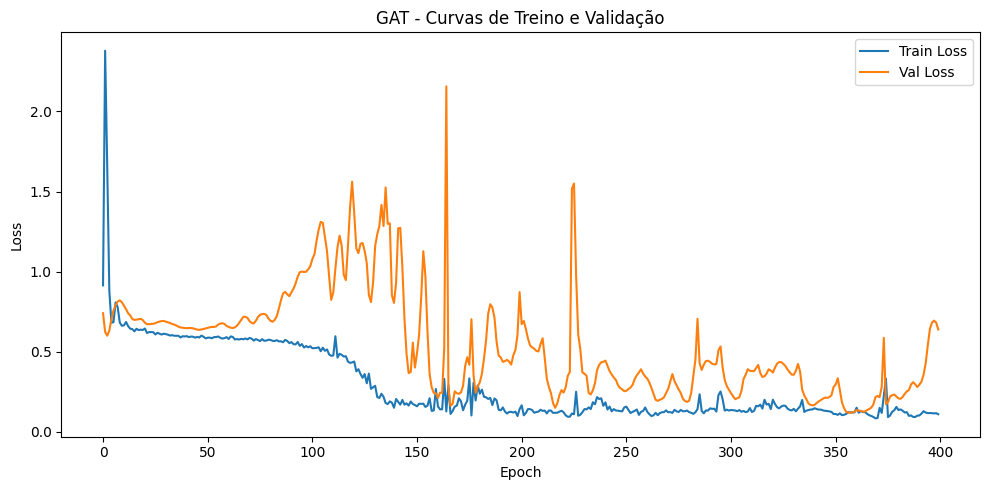


Evaluation on Validation Set:
  Accuracy: 0.986916
  Precision: 0.800000
  Recall: 0.615385
  F1 Score: 0.695652
  AUC: 0.992042
  False Positives: 2
  False Negatives: 5
  Percentage of misinformers identified: 61.53846%

Evaluation on Test Set:
  Accuracy: 0.972093
  Precision: 0.500000
  Recall: 0.300000
  F1 Score: 0.375000
  AUC: 0.945167
  False Positives: 9
  False Negatives: 21
  Percentage of misinformers identified: 30.00000%

Evaluation on Complete Set:
  Accuracy: 0.978747
  Precision: 0.600000
  Recall: 0.409091
  F1 Score: 0.486486
  AUC: 0.973601
  False Positives: 36
  False Negatives: 78
  Percentage of misinformers identified: 40.90909%


In [7]:
csv_file_path = 'users_selected_features.csv'
graph = CreateMessageGraph(csv_file_path)
print(f'Number of nodes: {graph.number_of_nodes()}')
print(f'Number of edges: {graph.number_of_edges()}')

nodes = list(graph.nodes())
pyg_data = from_networkx(graph)
node_features = ExtractNodeFeatures(graph, node_list=nodes)
labels = torch.tensor([graph.nodes[n]['disinformer'] for n in nodes], dtype=torch.long)

data = Data(x=torch.tensor(node_features, dtype=torch.float),
            edge_index=pyg_data.edge_index,
            y=labels)

train_mask, val_mask, test_mask = CreateGraphSplits(graph, node_features, labels,
                                                    val_ratio=0.10, test_ratio=0.20, random_state=42)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

input_dim = node_features.shape[1]
hidden_dim1 = DEFAULT_HIDDEN_DIM1
hidden_dim2 = DEFAULT_HIDDEN_DIM2
output_dim = 2
dropout_rate = DEFAULT_DROPOUT_RATE
lr = DEFAULT_LEARNING_RATE
weight_decay = DEFAULT_WEIGHT_DECAY

print("\nIniciando k-fold cross-validation com GAT...")
cv_results = KFoldCrossValidation(data, k=5, epochs=300, hidden_dim1=hidden_dim1,
                                  hidden_dim2=hidden_dim2, dropout_rate=dropout_rate,
                                  lr=lr, weight_decay=weight_decay,
                                  heads_layer1=4, heads_layer2=4, final_heads=1, attn_dropout=0.2)

print("\nTreinando modelo final GAT no conjunto de treino completo...")
X_np = node_features
train_idx_np = data.train_mask.cpu().numpy()
scaler = StandardScaler().fit(X_np[train_idx_np])
X_scaled = scaler.transform(X_np)
data.x = torch.tensor(X_scaled, dtype=torch.float)

model = GATNet(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate,
               heads_layer1=4, heads_layer2=4, final_heads=1, attn_dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
class_counts = torch.bincount(data.y[data.train_mask])
total_samples = data.train_mask.sum().item()
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts.float().clamp(min=1)))
criterion = torch.nn.NLLLoss(weight=class_weights)

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
FINAL_EARLY_STOPPING_PATIENCE = 160
FINAL_EPOCHS = 400
train_losses, val_losses = [], []

for epoch in range(FINAL_EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    val_losses.append(val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= FINAL_EARLY_STOPPING_PATIENCE:
        print(f"Early stopping no epoch {epoch}")
        break
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

if best_model_state:
    model.load_state_dict(best_model_state)

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('GAT - Curvas de Treino e Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('gat_training_curves.png')
plt.show()

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    val_probs = torch.exp(out[data.val_mask])[:, 1].cpu().numpy()
    val_labels = data.y[data.val_mask].cpu().numpy()
threshold = FindBestThreshold(val_labels, val_probs)

val_metrics = EvaluateModel(model, data, data.val_mask, threshold=threshold, dataset_name='Validation Set', return_metrics=True)
test_metrics = EvaluateModel(model, data, data.test_mask, threshold=threshold, dataset_name='Test Set', return_metrics=True)
full_metrics = EvaluateModel(model, data, None, threshold=threshold, dataset_name='Complete Set', return_metrics=True)